# Comparison of different approches

This notebook is meant to generate the figures of the paper out of a campaign of experiments. A file containing the preprocessed output of our campaign is included in the repository to generate the exploration curves. The other figures can only be generated with raw experimental data, which we have provided a few for representational purpose. 

To generate your own data, refer to [the README at the root of the repository](../README.md).

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import copy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
# plt.style.use('seaborn-darkgrid')
import os
import json
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.simplefilter("ignore")

In [2]:
def exploration(X_s, bins=10):
    """
    This function computes the exploration measure, i.e. the number of cells reached in the state space.

    Args:
        + X_s: the set of explored states
        + bins: the number of bins per dimension
    """

    n_samples, n_dim = X_s.shape
    hist, _ = np.histogramdd(X_s, bins=bins, range=np.array([[-1]*n_dim, [1]* n_dim]).T)
    
    return float(hist[hist>0].size) / float(hist.size)

In [3]:
# We load the experimental data
dataset = pd.DataFrame()
if False: # Set this to true to use your own experimental data
    folders = [fil for fil in os.listdir('./armballs/') if fil[0] == "M" or fil[0] == "R"]
    for fold in tqdm(folders):
        try:  
            with open(os.path.join('./armballs/' + fold, "config.json")) as f:
                config = json.load(f)

            explored_states = np.load(os.path.join('./armballs/' + fold, 'explored_states.npy'))

        except Exception as e:
            print("Folder %s failed with exception %s" % (fold, str(e)))
            continue

        max_iter = 10000
        n_epochs = 30
        for i in range(n_epochs):
            serie = copy.copy(config)
            iteration = int(i * max_iter / n_epochs)
            serie.update({'epoch': iteration})
            serie.update({'exploration_30': exploration(explored_states[:iteration, -2:], bins=30)})

            dataset = dataset.append(serie, ignore_index=True)
else:
    dataset = pd.read_pickle('armballs_dataset.pkl')

In [4]:
ds = dataset['name'].str.extract("^(.*)\:(armballs|Armball|Armarrow)")
dataset["algorithm"] = ds[0]
dataset = dataset.replace('MGE-REP_rep:betavae_nmodules:5_im:normal_env', 'MGE-betaVAE')
dataset = dataset.replace('MGE-REP_rep:vae_nmodules:5_im:normal_env', 'MGE-VAE')
dataset = dataset.replace('MGE-REP_rep:betavae_nmodules:1_im:normal_env', 'RGE-betaVAE')
dataset = dataset.replace('MGE-REP_rep:vae_nmodules:1_im:normal_env', 'RGE-VAE')
dataset = dataset.replace('MGE-FI_rep:modular_im:uniform_env', 'MGE-EFR')
dataset = dataset.replace('MGE-FI_rep:flat_im:uniform_env', 'RGE-EFR')
dataset = dataset.replace('RPE_env', 'RPE')

if False: 
    dataset.to_pickle(path='armballs_dataset.pkl')

## Comparison of Exploration Ratio through epochs

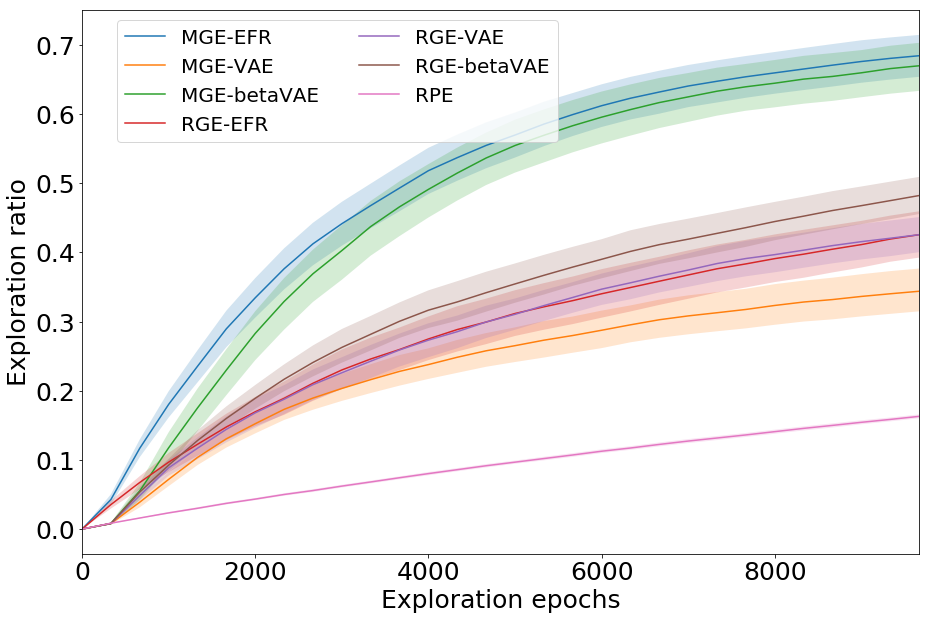

In [5]:
fontsize = 25
explo_noise_sdev = 0.05 # or 0.1
object_size = 0.1
interest_model = 'normal'
ds = dataset.fillna({'interest_model': interest_model})
ds = ds.fillna({'explo_noise_sdev': explo_noise_sdev})
ds = ds.query('explo_noise_sdev==@explo_noise_sdev').sort_values(['algorithm'])
ds = ds.query('object_size==@object_size')
# ds = ds.query('interest_model=="uniform" or interest_model=="normal"')
plt.figure(figsize=(15, 10))
sns.tsplot(data=ds, time='epoch', value='exploration_30', unit='name', condition='algorithm', ci=95)
plt.ylabel('Exploration ratio', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", fontsize=20, loc=1, frameon=1, ncol=2, fancybox=True, bbox_to_anchor=(.58, 1.));
# plt.savefig('figures/comparison_armballs_exploration_explonoise' + str(explo_noise_sdev) + '.png')

# Exploration Curves for all runs

This figures can only be generated from raw experimental results.

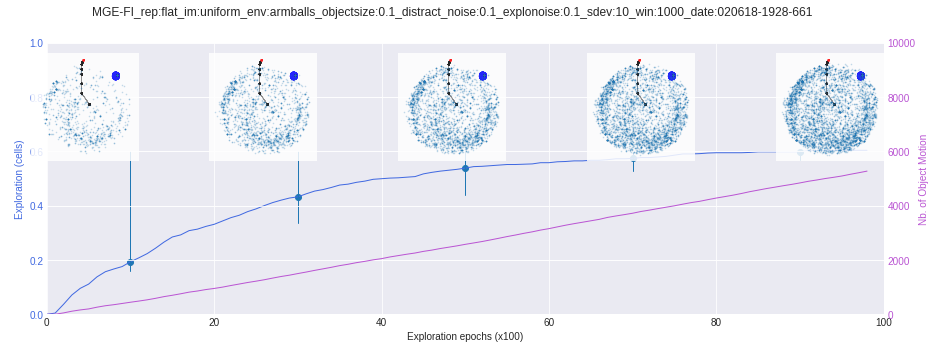

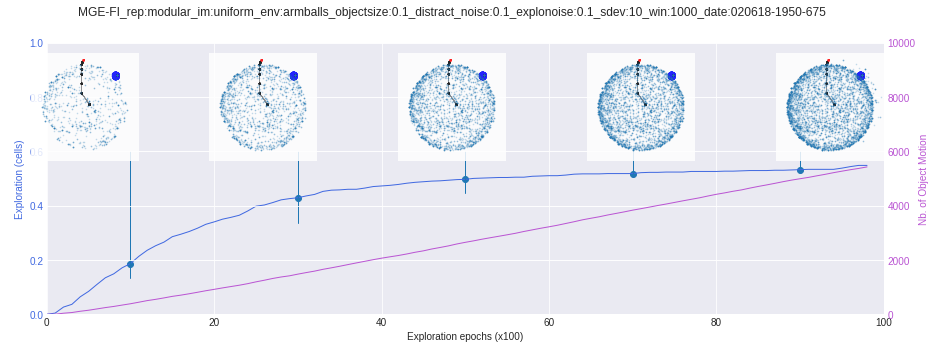

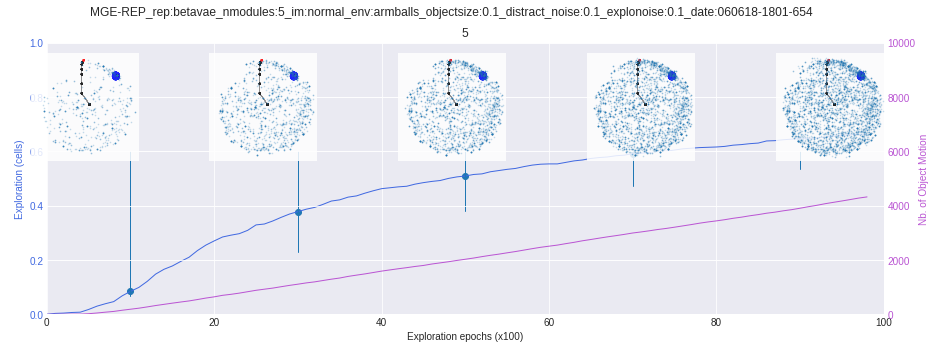

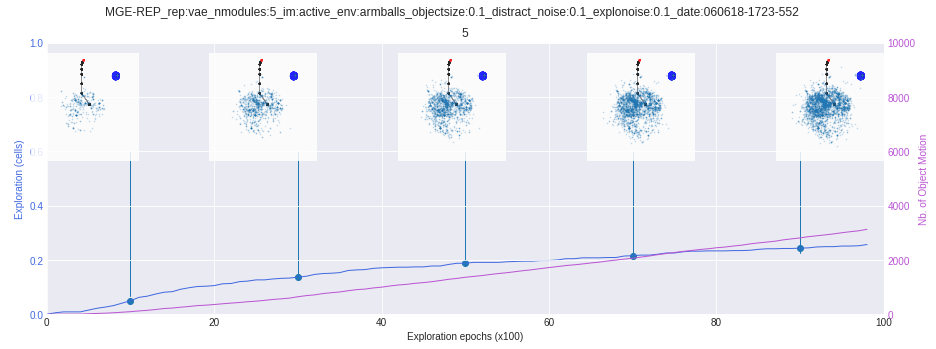

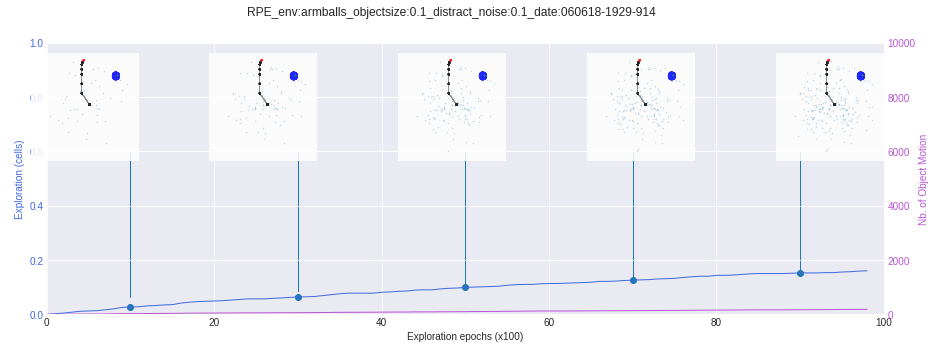

In [6]:
folders = [fil for fil in os.listdir('./armballs/') if fil[0] == "M" or fil[0] == "R"]

sorted_fold = folders
sorted_fold.sort()

for fold in sorted_fold:
    with open(os.path.join('./armballs/' + fold, "config.json")) as f:
        config = json.load(f)
    explored_states = np.load(os.path.join('./armballs/' + fold, 'explored_states.npy'))
    kls = np.zeros((99))
    expl = np.zeros((99))
    # X_real = sample_in_attainable(explored_states_history[498].shape[0], 'armball')
    for i in range(99):   
        #explored = explored_states_history[i*10][np.where(explored_states_history[i*10]!=[.6, .6])[1]]
        explored = explored_states[:i*100, -2:]
        kls[i] = exploration(explored, bins=30)
        expl[i] = np.sum(np.linalg.norm(explored_states[:i*100, -2:] - np.array([0.6, 0.6]), axis=1, ord=2) > 1e-3)
        #expl[i] /= explored_states_history[i*10].shape[0]

    arm = scipy.misc.imread('test.png')
    cmap='Blues'
    plt.style.use('seaborn-darkgrid')

    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(fold)
    try:
        plt.title(config['n_modules'])
    except:
        pass

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(kls,linewidth=1., color='royalblue')
    ax1.tick_params(axis='y', colors='royalblue')
    ax1.set_ylim(0, 1)
    ax1.set_yticks(np.linspace(0, 1, 6))
    ax1.set_xlim(0., 100.)
    ax1.set_xlabel("Exploration epochs (x100)")
    ax1.set_ylabel("Exploration (cells)", color='royalblue')
    ax1.add_line(matplotlib.lines.Line2D([5 * 2, 5 * 2],   [kls[5] + .05, 0.6], linewidth=1))
    ax1.add_line(matplotlib.lines.Line2D([15 * 2, 15 * 2], [kls[15] + .05, 0.6], linewidth=1))
    ax1.add_line(matplotlib.lines.Line2D([25 * 2, 25 * 2], [kls[25] + .05, 0.6], linewidth=1))
    ax1.add_line(matplotlib.lines.Line2D([35 * 2, 35 * 2], [kls[35] + .05, 0.6], linewidth=1))
    ax1.add_line(matplotlib.lines.Line2D([45 * 2, 45 * 2], [kls[45] + .05, 0.6], linewidth=1))
    points = [10, 30, 50, 70, 90]
    ax1.scatter(points, kls[points])

    ax1_2 = ax1.twinx()
    ax1_2.locator_params(axis='y', nticks=6)
    ax1_2.plot(expl, linewidth=1., c='mediumorchid')
    ax1_2.tick_params(axis='y', colors='mediumorchid')
    ax1_2.set_ylim(0., 3000.)
    ax1_2.set_yticks(np.linspace(0, 10000., 6))
    ax1_2.set_ylabel("Nb. of Object Motion", color='mediumorchid')
    ax1_2.set_xlim(0., 100.)

    ax = fig.add_axes([0.01, 0.55, .3, .3])
    ax.imshow(arm, extent=[-1, 1, -1, 1], alpha=.85)
    ax.scatter(explored_states[:2000, 0], explored_states[:2000, 1], s=.5, alpha=.2)
    ax.axis("off")

    ax = fig.add_axes([0.175, 0.55, .3, .3])
    ax.imshow(arm, extent=[-1, 1, -1, 1], alpha=.85)
    ax.scatter(explored_states[:4000, 0], explored_states[:4000, 1], s=.5, alpha=.2)
    ax.axis("off")

    ax = fig.add_axes([0.35, 0.55, .3, .3])
    ax.imshow(arm, extent=[-1, 1, -1, 1], alpha=.85)
    ax.scatter(explored_states[:6000, 0], explored_states[:6000, 1], s=.5, alpha=.2)
    ax.axis("off")

    ax = fig.add_axes([0.525, 0.55, .3, .3])
    ax.imshow(arm, extent=[-1, 1, -1, 1], alpha=.85)
    ax.scatter(explored_states[:8000, 0], explored_states[:8000, 1], s=.5, alpha=.2)
    ax.axis("off")

    ax = fig.add_axes([0.70, 0.55, .3, .3])
    ax.imshow(arm, extent=[-1, 1, -1, 1], alpha=.85)
    ax.scatter(explored_states[:10000, 0], explored_states[:10000, 1], s=.5, alpha=.2)
    ax.axis("off");

    plt.show()

## Interest Curve of a single run
This figure can only be generated from raw experimental results.

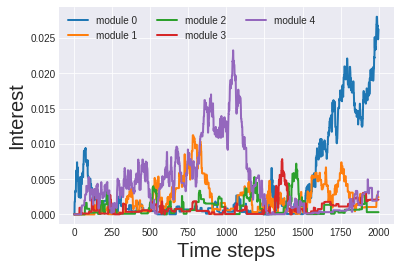

In [7]:
fold = 'MGE-REP_rep:vae_nmodules:5_im:active_env:armballs_objectsize:0.1_distract_noise:0.1_explonoise:0.1_date:060618-1723-552/'
interests_evolution = np.load(os.path.join('./armballs/' + fold, 'interests_evolution.npy'))
fig, ax = plt.subplots()
ax.plot(interests_evolution[:], lw=2)
ax.legend(["module 0", "module 1", "module 2", "module 3", "module 4", "module 5"], ncol=3)
ax.set_xlabel('Time steps', fontsize=20)
ax.set_ylabel('Interest', fontsize=20);
# plt.savefig('figures/interest_mge_vae.png')